# Подготовительный этап

In [1]:
import os
import sys
import re
import gc
import platform
import random
import argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import einops

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
import glob
import cv2

from numpy import array
from numpy import argmax

from tqdm import tqdm
from tqdm.contrib import tzip

import wandb

import warnings

warnings.simplefilter('ignore')

c:\Users\NVME_1TB\Desktop\mephi\Neural_spr_2025\.neural_spr_2025_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Настройка конфигураций
conf = dict(
    MAX_FRAMES=12,
    EPOCHS=10,
    LR=2e-4,
    IMG_SIZE=(224, 224),
    FEATURE_EXTRACTOR='resnext101_64x4d',
    DR_RATE=0.3,
    NUM_CLASSES=12,
    RNN_HIDDEN_SIZE=256,
    RNN_LAYERS=1,
    TRAIN_BS=7, # количество батчей на трейне
    VALID_BS = 7, # количество батчей на валидации
    NUM_WORKERS = 4, # количество процессоров которые используются

    MODEL_PATH='submit/weights/model_resnext50_32x4d.pt',
    video_train_path='data/train',
    video_test_path='data/test'
    )

# Исследование данных

In [3]:
import pandas as pd

df_train = pd.read_csv('data/train.csv')
sample_submit = pd.read_csv('data/sample_submit.csv')

df_train.shape, sample_submit.shape

((290, 2), (435, 3))

In [4]:
df_train.head()

,path,labels
0,port_before_sunrise_preview.mp4,sunset
1,Louisiana speeding boat on Mississippi River_p...,cloud
2,170509A_Vietnam_03_preview.mp4,water
3,Croatia water on rocks at high tide pan_previe...,water
4,Arizona zoom on sunset mountain_preview.mp4,sunset


In [5]:
df_train['labels'].value_counts()

labels
water            68
cloud            41
car              33
food             30
sunset           29
flower           29
animal           21
dance            17
cloud, water     11
fire              6
cloud, sunset     3
cloud. water      1
water, sunset     1
Name: count, dtype: int64

In [6]:
df_train['labels'] = df_train['labels'].str.replace('.',',')

df_train['labels'].value_counts()

labels
water            68
cloud            41
car              33
food             30
sunset           29
flower           29
animal           21
dance            17
cloud, water     12
fire              6
cloud, sunset     3
water, sunset     1
Name: count, dtype: int64

In [7]:
print(f"Количество размеченных видео в DataFrame: {len(set(df_train['path'].values))}")
print(f"Количество видео в папке train/: {len(set(os.listdir('data/train')))}")

Количество размеченных видео в DataFrame: 290
Количество видео в папке train/: 428


In [8]:
import os
print(len(os.listdir('data/train')))
print(len(os.listdir('data/test')))

428
435


In [9]:
intersect = set(df_train['path'].values) & set(os.listdir('data/train'))
len(intersect)

290

# Подготовка данных
### 290 / 428 размечено )))))))


In [10]:
# Размелим датасет на обучающую и валидационную выборку, т.е. train_test_split, только самописный

df_valid = df_train.sample(frac=0.2) #берем рандомно 20% от исходного датасета
df_train = df_train[~df_train.index.isin(df_valid.index)]# теперь удалим эти 20% из исходного, это и останется на трейн

df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

print(f'Train shape: {df_train.shape}')
print(f'Valid shape: {df_valid.shape}')

Train shape: (232, 2)
Valid shape: (58, 2)


In [11]:
def read_video(path, img_size, transform=None, frames_num=11):
    frames = []
    cap = cv2.VideoCapture(path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length // (frames_num)

    current_frame = 1
    for i in range(length):
        ret, frame = cap.read(current_frame)

        if ret and i == current_frame and len(frames) < frames_num:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # все кадры в BGR (поэтому перводим в RGB)
            frame = cv2.resize(frame, img_size)

            frames.append(frame)
            current_frame += N

    cap.release()

    return frames

example_path = 'data/test/000691821-mexico-puerto-vallarta-ocean_preview.mp4'
example_video = read_video(path=example_path, img_size=conf['IMG_SIZE'], transform=None, frames_num=11)
len(example_video), example_video[0].shape

(11, (224, 224, 3))

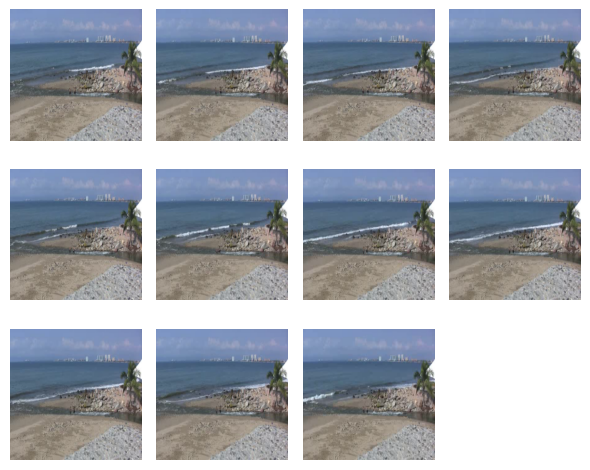

In [12]:
import matplotlib.pyplot as plt

n = len(example_video)
cols = 4  # Кол-во колонок в гриде
rows = (n + cols - 1) // cols  # Вычисляем нужное кол-во строк

plt.figure(figsize=(6, 5))
for i, img in enumerate(example_video):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img) 
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
unique_labels = df_train['labels'].unique()
classes = {label: idx for idx, label in enumerate(unique_labels)}
classes

{'sunset': 0,
 'cloud': 1,
 'water': 2,
 'food': 3,
 'flower': 4,
 'cloud, water': 5,
 'animal': 6,
 'car': 7,
 'dance': 8,
 'fire': 9,
 'cloud, sunset': 10,
 'water, sunset': 11}

In [56]:
class RSNADataset(Dataset):
    # def __init__ - конструктор класс
    def __init__(self, df,  conf, is_test=False):
        self.conf = conf
        self.df = df
        self.transform = A.Compose([
            A.Normalize(),
            # ToTensorV2(p=1.0),
        ],p=1.)

        self.is_test = is_test
        self.samples = []
        # Создаём словарь: класс -> индекс
        self.cls = {'cloud': 0, 'water': 1, 'sunset': 2, 'flower': 3, 'car': 4, 'food': 5,
                    'cloud, water': 6, 'animal': 7, 'dance': 8, 'fire': 9,
                    'cloud, sunset': 10, 'water, sunset': 11}

        if is_test:
            for path, label in tzip(df.path, df.labels):
                # read_video(путь, размер, кол-во кадров)
                frames = read_video(self.conf['video_test_path'] + f'/{path}',
                                    self.conf['IMG_SIZE'],
                                    self.conf['MAX_FRAMES'])
                
                self.samples +=[{'label': self.cls[str(label)],'frames': frames}]
        else:
            for path, label in tzip(df.path, df.labels):
                # read_video(путь, размер, кол-во кадров)
                frames = read_video(self.conf['video_train_path'] + f'{path}',
                                    self.conf['IMG_SIZE'],
                                    self.conf['MAX_FRAMES'])
                
                self.samples +=[{'label': self.cls[str(label)],'frames': frames}]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        frames = sample['frames']
        # print(len(frames), frames[0].shape)

        # for i in range(len(frames)):
        #     frames[i] = frames[i] / 255.0

        # if self.transform is not None:
        #     for i in range(len(frames)):
        #         frames[i] = self.transform(image=np.array(frames[i]))['image']

        # torch.from_numpy - перевод в тензоры
        # print(torch.from_numpy(frames, axis=2).shape)
        print(torch.from_numpy(np.stack(frames, axis=2)).shape)
        frames_tr = torch.from_numpy(np.stack(frames, axis=2)).permute(2, 3, 0, 1)
        print(frames_tr.shape)
        if self.is_test:
            return frames_tr
        else:
            label = torch.tensor(sample['label']).long()
            return frames_tr, label

In [15]:


train_data = RSNADataset(df_train, conf)

train_loader = DataLoader(
        train_data,
        batch_size=conf['TRAIN_BS'],
        shuffle=False
    )

valid_data = RSNADataset(df_valid, conf)

valid_loader = DataLoader(
        valid_data,
        batch_size=conf['VALID_BS'],
        shuffle=False
    )
print(1)
train_loader

100%|██████████| 58/58 [00:11<00:00,  5.11it/s]

1


In [16]:
for frames_tr, label in train_loader:
    print(frames_tr.shape)
    print(label.shape)
    break

torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([7, 11, 3, 224, 224])
torch.Size([7])


In [17]:
print(f'Sample len (это эквивалентно количество видео): {len(train_data.samples)}') # всего в датасете 522 видео
print(f'Что лежит в одном видео: {len(train_data.samples[0])}') # в каждом видео лежат два ключа
print(f'Какие ключи: {train_data.samples[0].keys()}')# в каждом видео лежат два ключа
print(f'Что лежит в ключе labels: {train_data.samples[0]["label"]}')# ключ label
print(f'размерность данных по ключу frames: {len(train_data.samples[0]["frames"])}')# лежит 6, так как кадров из видео 6
print(f'Размерность одного кадра, frame: {train_data.samples[0]["frames"][0].shape}') # что лежит в одном кадре, его размерность

Sample len (это эквивалентно количество видео): 232
Что лежит в одном видео: 2
Какие ключи: dict_keys(['label', 'frames'])
Что лежит в ключе labels: 2
размерность данных по ключу frames: 11
Размерность одного кадра, frame: (224, 224, 3)


# Подготовка модели

In [18]:
## Model Class

class ResNextModel(nn.Module):
    def __init__(self, conf):
        super(ResNextModel, self).__init__()
        self.conf = conf
        self.backbone = timm.create_model(self.conf['FEATURE_EXTRACTOR'],
                                          pretrained=True)

    def forward(self, x):
        return self.backbone(x)


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class RSNAModel(nn.Module):
    def __init__(self, conf, pretrained=True):
        super(RSNAModel, self).__init__()
        self.conf = conf
        self.backbone = ResNextModel(self.conf)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.num_features = self.backbone.backbone.fc.in_features

        self.backbone.backbone.fc = Identity()
        self.dropout = nn.Dropout(self.conf['DR_RATE'])
        self.rnn = nn.LSTM(self.num_features, self.conf['RNN_HIDDEN_SIZE'],
                           self.conf['RNN_LAYERS'], dropout=0.1,
                           batch_first=True, bidirectional=True)  # bidirectional=True
        self.fc1 = nn.Linear(self.conf['RNN_HIDDEN_SIZE'] * 2, self.conf['NUM_CLASSES']) #выходной слой

    def forward(self, x):
        b, f, c, h, w = x.shape
        # print(x.reshape(b * f, c, h, w).shape)
        x = self.backbone(x.reshape(b * f, c, h, w))
        # print(x.shape)
        x = x.reshape(b, f, self.num_features)
        # print(x.shape)
        x, _ = self.rnn(x)
        # print(x.shape)
        x = self.dropout(x[:, -1])  #
        # print(x.shape, self.num_features)
        x = self.fc1(x)
        return x

In [19]:
def train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch, device, log_wandb=True, verbose=False):
    """
    Trains model for one epoch
    """
    model.train()
    running_loss = 0
    # for i in tqdm([]))
    prog_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for batch, (frames, targets) in prog_bar:
        optimizer.zero_grad()

        frames = frames.to(device, torch.float)
        targets = targets.to(device)

        # # Re arrange the frames in the format our model wants to recieve
        preds = model(frames)
        loss = loss_fn(preds, targets)

        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        running_loss += loss_item

        prog_bar.set_description(f"loss: {loss_item:.4f}")

        if log_wandb == True:
            wandb_log(
                batch_train_loss=loss_item
            )

        if verbose == True and batch % 20 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")

    avg_loss = running_loss / len(train_dataloader)

    return avg_loss

@torch.no_grad()
# def train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch, device, log_wandb=True, verbose=False):
def valid_one_epoch(model, valid_dataloader, loss_fn, epoch, device, log_wandb=True, verbose=False):
    """
    Validates the model for one epoch
    """
    model.eval()
    running_loss = 0
    prog_bar = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader))
    for batch, (frames, targets) in prog_bar:
        frames = frames.to(device, torch.float)
        targets = targets.to(device)

        # Re arrange the frames in the format our model wants to recieve
        preds = model(frames)
        loss = loss_fn(preds, targets)

        loss_item = loss.item()
        running_loss += loss_item

        prog_bar.set_description(f"val_loss: {loss_item:.4f}")

        if log_wandb == True:
            wandb_log(
                batch_val_loss=loss_item
            )

        if verbose == True and batch % 10 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")

    avg_val_loss = running_loss / len(valid_dataloader)

    return avg_val_loss

In [20]:
# Функция main, которая собирает все вместе
# она принимает разные конфигурации для выполнения всех программ
# лоадер данных - df_loader
# df - это датафрейм (где путь, класс)
# output_path - путь куда сохранить ответы
# device - GPU/CPU - на чем делать вычисления
def main(conf, train_loader, valid_loader,  output_path, device):

    # создаем модель
    model = RSNAModel(conf)
    # передаем модели на чем делать вычисления GPU/CPU
    model = model.to(device)

    # Тут начинается обучение модели
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=conf['LR'])
    # SGD

    train_loss_fn = nn.CrossEntropyLoss()
    valid_loss_fn = nn.CrossEntropyLoss()

    # train_loss_fn = nn.BCEWithLogitsLoss()
    # valid_loss_fn = nn.BCEWithLogitsLoss()

    print(f"\nUsing Backbone: {conf['FEATURE_EXTRACTOR']}")

    current_loss = 1000
    for epoch in range(conf['EPOCHS']):
        print(f"\n{'--'*8} EPOCH: {epoch+1} {'--'*8}\n")

        train_loss = train_one_epoch(model,
                                     train_loader,
                                     optimizer,
                                     train_loss_fn,
                                     epoch=epoch, device=device, log_wandb=log_wandb)

        valid_loss = valid_one_epoch(model,
                                     valid_loader,
                                     valid_loss_fn,
                                     epoch=epoch, device=device, log_wandb=log_wandb)

        print(f"val_loss: {valid_loss:.4f}")

        if log_wandb == True:
            wandb_log(
                    train_loss=train_loss,
                    valid_loss=valid_loss
            )

        if valid_loss < current_loss:
            current_loss = valid_loss
            torch.save(model.state_dict(), f"model_{conf['FEATURE_EXTRACTOR']}.pt")
    
    # тут происходит предсказание ответа
    gt = []
    pred = [] # массив куда будем сохранять ответы
    model.eval()

    # prog_bar - это просто чтобы красиво выводился процесс вычисления
    # в виде бегущей крассивой штукой и показом процента выполнения
    gt = []
    pred = []
    model.eval()
    prog_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    for batch, (frames, targets) in prog_bar:
        frames = frames.to('cuda').float()
        gt +=  list(targets.numpy())
        with torch.no_grad():

            pred += list(model(frames).argmax(dim=-1).to('cpu').flatten().numpy())

    torch.save(model.state_dict(),'sample_model.pt')

    # сохраняем ответы в датафрейм с путями в новую колонку labels_pred
    df_valid['labels_pred'] = pred

    # сохраняем ответы в файл csv
    os.makedirs(output_path, exist_ok=True)
    df_valid['labels_pred'].to_csv(output_path + 'predictions.csv')

In [21]:
import torch
print(torch.version.cuda)      # Should NOT be None
print(torch.backends.cudnn.enabled)
torch.cuda.is_available()

11.8
True


True

In [ ]:

# Настройка конфигураций
conf = dict(
    MAX_FRAMES=12,
    EPOCHS=10,
    LR=2e-4,
    IMG_SIZE=(224, 224),
    FEATURE_EXTRACTOR='resnet18',
    DR_RATE=0.3,
    NUM_CLASSES=12,
    RNN_HIDDEN_SIZE=256,
    RNN_LAYERS=1,
    TRAIN_BS=7, # количество батчей на трейне
    VALID_BS = 7, # количество батчей на валидации
    NUM_WORKERS = 4, # количество процессоров которые используются

    MODEL_PATH='submit/weights/model_resnet18.pt',
    video_train_path='data/train',
    video_test_path='data/test'
    )
# ВСЕ ЗАПУСКАЕМ
log_wandb = False

if torch.cuda.is_available():
    print("Using GPU: {}\n".format(torch.cuda.get_device_name()))
    device = torch.device('cuda')
else:
    print("\nGPU not found. Using CPU: {}\n".format(platform.processor()))
    device = torch.device('cpu')

main(conf, train_loader, valid_loader, 'output/', device)

In [23]:
unique_labels = df_train['labels'].unique()
classes = {label: idx for idx, label in enumerate(unique_labels)}
df_valid['labels_idx'] = df_valid['labels'].map(classes)

df_valid.head()

,path,labels,labels_pred,labels_idx
0,LobsterinTankH264_preview.mp4,water,3,2
1,181015_09_Timelapses_06_preview.mp4,car,4,7
2,Montana Glacier National Park lake in sun_prev...,cloud,1,1
3,FREEStockVideoDOWNLOADVictrolaRecordPlayer2Pac...,dance,8,8
4,_California San Francisco cable car enters tur...,car,4,7


In [24]:
from sklearn.metrics import accuracy_score, f1_score

print(accuracy_score(df_valid['labels_idx'].values, df_valid['labels_pred'].values))
print(f1_score(df_valid['labels_idx'].values, df_valid['labels_pred'].values, average='weighted'))

0.1724137931034483
0.1110016420361248


<Axes: >

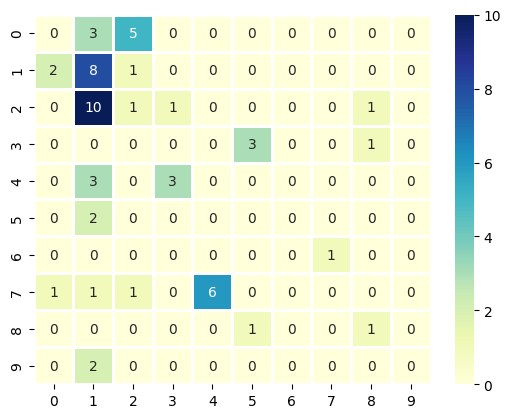

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(df_valid['labels_idx'].values, df_valid['labels_pred'].values)

sns.heatmap(conf_matrix, annot = True, cmap="YlGnBu", linecolor='white', linewidths=1)

# Подготовка ответов для test

In [26]:
sample_submit.columns = ['index', 'path', 'labels']
sample_submit['labels'] = 'animal'
sample_submit

,index,path,labels
0,0,Arizona sunset with creosote bush_preview.mp4,animal
1,1,_import_616e7f78a17260.13545125_preview.mp4,animal
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,animal
3,3,Pordeitev_smrek_preview.mp4,animal
4,4,City street time lapse-H264 75_preview.mp4,animal
...,...,...,...
430,430,Sydney_storm_preview.mp4,animal
431,431,Alaska spring shrub in wind_preview.mp4,animal
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal


In [ ]:
import os

def check_filenames_match(folder_path, df):
    # Get the set of filenames in the folder
    folder_files = set(os.listdir(folder_path))

    # Get the set of filenames from the DataFrame column
    df_files = set(df['file_name'])

    # Find differences
    only_in_folder = folder_files - df_files
    only_in_df = df_files - folder_files

    if not only_in_folder and not only_in_df:
        print("✅ All filenames match!")
    else:
        if only_in_folder:
            print(f"⚠️ Files in folder but not in DataFrame ({len(only_in_folder)}):")
            for f in sorted(only_in_folder):
                print("  ", f)

        if only_in_df:
            print(f"⚠️ Files in DataFrame but not in folder ({len(only_in_df)}):")
            for f in sorted(only_in_df):
                print("  ", f)

check_filenames_match("data/test", df)

,index,path,labels
0,0,Arizona sunset with creosote bush_preview.mp4,animal
1,1,_import_616e7f78a17260.13545125_preview.mp4,animal
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,animal
3,3,Pordeitev_smrek_preview.mp4,animal
4,4,City street time lapse-H264 75_preview.mp4,animal
...,...,...,...
430,430,Sydney_storm_preview.mp4,animal
431,431,Alaska spring shrub in wind_preview.mp4,animal
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal


In [ ]:

test_data = RSNADataset(sample_submit, conf, is_test=True)

print(len(test_data))
test_loader = DataLoader(
        test_data,
        batch_size=5,
        shuffle=False
    )


  1%|          | 5/435 [00:01<02:42,  2.64it/s]


KeyboardInterrupt: 

In [68]:
len(test_loader)

87

In [69]:
for frames in test_loader:
    print(frames.shape)
    break

torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([5, 11, 3, 224, 224])


In [70]:
model = RSNAModel(conf)
# передаем модели на чем делать вычисления GPU/CPU
model.load_state_dict(torch.load('sample_model.pt', weights_only=True))
model = model.to(device)

In [71]:
# тут происходит предсказание ответа
gt = []
pred = [] # массив куда будем сохранять ответы
model.eval()

# prog_bar - это просто чтобы красиво выводился процесс вычисления
# в виде бегущей крассивой штукой и показом процента выполнения
gt = []
pred = []
model.eval()
prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))

for batch, frames in prog_bar:
    frames = frames.to('cuda').float()
    with torch.no_grad():
        pred += list(model(frames).argmax(dim=-1).to('cpu').flatten().numpy())

# сохраняем ответы в датафрейм с путями в новую колонку labels_pred
sample_submit['labels_pred'] = pred

  1%|          | 1/87 [00:00<00:14,  6.08it/s]

torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])


  2%|▏         | 2/87 [00:00<00:12,  6.57it/s]

torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])


  5%|▍         | 4/87 [00:00<00:11,  7.08it/s]

torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])


  7%|▋         | 6/87 [00:00<00:10,  7.39it/s]

torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])


  9%|▉         | 8/87 [00:01<00:10,  7.65it/s]

torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])


 10%|█         | 9/87 [00:01<00:10,  7.62it/s]

torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])


 13%|█▎        | 11/87 [00:01<00:12,  6.10it/s]

torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])


 15%|█▍        | 13/87 [00:01<00:11,  6.64it/s]


torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])
torch.Size([224, 224, 11, 3])
torch.Size([11, 3, 224, 224])


ValueError: need at least one array to stack

In [ ]:
my_submit = pd.read_csv('data/sample_submit.csv')
my_submit

,index,file_name,label
0,0,Arizona sunset with creosote bush_preview.mp4,"sunset, cloud"
1,1,_import_616e7f78a17260.13545125_preview.mp4,"sunset, cloud"
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,"sunset, cloud"
3,3,Pordeitev_smrek_preview.mp4,"sunset, cloud"
4,4,City street time lapse-H264 75_preview.mp4,"sunset, cloud"
...,...,...,...
430,430,Sydney_storm_preview.mp4,animal
431,431,Alaska spring shrub in wind_preview.mp4,animal
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal


In [ ]:
my_submit.columns = ['index', 'file_name', 'label']
my_submit['label'] = sample_submit['labels_pred']

my_submit['label'] = my_submit['label'].map(id2label)
my_submit[['index','file_name', 'label']].to_csv('my_baseline_submit.csv', index=False)

KeyError: 'labels_pred'